## Problem Statement
Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

They first identify a set of employees based on recommendations/ past performance
Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion
For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.




<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/09/wns_hack_im_1.jpg">


In [8]:
# To suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For setting working director
import os
os.chdir(r'C:\Users\mohammad shafin\Desktop\wns_hack')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#machine learning libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, recall_score, roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale

# variables
iter_no = 5
gp_params = {'alpha': 1e-5}
cv_splits = 8
seed = 42


In [9]:
data = pd.read_csv('train.csv')

In [10]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


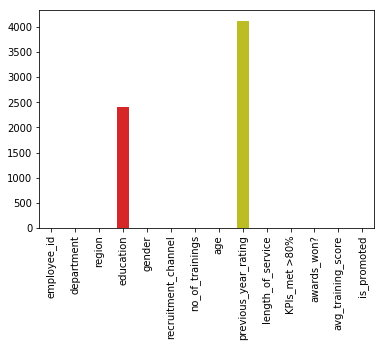

In [11]:
data.isna().sum().plot(kind='bar')
plt.show()

In [12]:

def treesCV(eta, gamma,max_depth,min_child_weight,subsample,colsample_bytree,n_estimators):
    #function for cross validation gradient boosted trees
    return cross_val_score(xgb.XGBRegressor(objective='binary:logistic',
    											tree_method = 'hist',
                                                learning_rate=max(eta,0),
                                                gamma=max(gamma,0),
                                                max_depth=int(max_depth),
                                                min_child_weight=int(min_child_weight),
                                                silent=True,
                                                subsample=max(min(subsample,1),0.0001),
                                                colsample_bytree=max(min(colsample_bytree,1),0.0001),
                                                n_estimators=int(n_estimators),
                                                seed=42,nthread=-1), X=X_train, y=y_train, scoring=None, cv=cv_splits, n_jobs=-1).mean()




def data_prep(data_df):

    #how to handle types
    data_df_num = data_df.select_dtypes(exclude=object)
    data_df_obj = data_df.select_dtypes(include=object)

    #how to handle nan
    data_df_num = data_df_num.fillna(data_df_num.mean())
    for column in data_df_num.columns:
        data_df_num[column] = scale(data_df_num[column])
    #get dummy variables
    data_df_obj = data_df_obj.fillna("UNKNOWN")
    data_df_obj = pd.get_dummies(data_df_obj, dummy_na=True)

    data_concat = pd.concat([data_df_num, data_df_obj],axis=1)

    return data_concat.drop(['department_nan','department_R&D','department_Finance','department_Operations',
                             'education_nan','education_Below Secondary',
                             'region_region_18','region_nan','region_region_10','region_region_12','region_region_24',
                             'region_region_31', 'region_region_33','region_region_1','region_region_13','region_region_14',
                             'region_region_15','region_region_27','region_region_30','region_region_8','region_region_3',
                             'recruitment_channel_sourcing','recruitment_channel_other','recruitment_channel_nan',
                             'gender_m','gender_nan','region_region_21','region_region_6', 'region_region_5'],axis=1) 

In [59]:

def treesLGBCV(eta, max_depth,min_child_weight,subsample,colsample_bytree,n_estimators):
    #function for cross validation gradient boosted trees
    return cross_val_score(lgb.LGBMRegressor(objective='binary',
    											boosting_type = 'goss',
                                                learning_rate=max(eta,0),
                                                max_depth=int(max_depth),
                                                min_child_weight=int(min_child_weight),
                                                silent=True,
                                                subsample=max(min(subsample,1),0.0001),
                                                colsample_bytree=max(min(colsample_bytree,1),0.0001),
                                                n_estimators=int(n_estimators),
                                                random_state=42,nthread=-1), X=X_train, y=y_train, scoring=None, cv=cv_splits, n_jobs=-1).mean()





In [13]:

# reading data
data_train = pd.read_csv('train.csv', sep=',',encoding="ISO-8859-1")
data_train['is_promoted'] = data_train['is_promoted'].astype('object') 
data_train = data_train.set_index("employee_id")
data_train = data_prep(data_train)

data_pred = pd.read_csv('test.csv', sep=',',encoding="ISO-8859-1")
data_pred = data_pred.set_index("employee_id")
data_pred = data_prep(data_pred)




In [14]:
data_train.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Analytics,department_HR,...,region_region_32,region_region_34,region_region_4,region_region_7,region_region_9,education_Bachelor's,education_Master's & above,education_UNKNOWN,gender_f,recruitment_channel_referred
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.415276,0.025598,1.378900,0.500460,1.356878,-0.154018,-1.075931,0,0,0,...,0,0,0,1,0,0,1,0,1,0
65141,-0.415276,-0.627135,1.378900,-0.437395,-0.736986,-0.154018,-0.253282,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7513,-0.415276,-0.104948,-0.271742,0.265996,-0.736986,-0.154018,-1.001145,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2542,1.226063,0.547785,-1.922383,0.969387,-0.736986,-0.154018,-1.001145,0,0,0,...,0,0,0,0,0,1,0,0,0,0
48945,-0.415276,1.331064,-0.271742,-0.906322,-0.736986,-0.154018,0.718939,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [32]:
#train test split doesnt actually split
X_train, X_test, y_train, y_test = train_test_split(np.array(data_train.drop(['is_promoted'],axis=1)), np.array(data_train['is_promoted']), test_size=0, random_state=42)
X_test1 = np.array(data_pred)


In [55]:

#Bayesian Hyper parameter optimization of gradient boosted trees
treesBO = BayesianOptimization(treesCV,{'eta':(0.10,0.12),
                                        'gamma':(10,13),
                                        'max_depth':(540,580),
                                        'min_child_weight':(0.5,0.7),
                                        'subsample':(0.4,0.7),
                                        'colsample_bytree':(0.5,0.6),
                                        'n_estimators':(1600,1800)})
treesBO.maximize(n_iter=iter_no, **gp_params)
tree_best = treesBO.res['max']




Initialization
--------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |       eta |     gamma |   max_depth |   min_child_weight |   n_estimators |   subsample | 
    1 | 03m57s |    0.37750 |             0.5219 |    0.1196 |   10.6991 |    568.4526 |             0.5780 |      1609.2449 |      0.5105 | 
    2 | 05m38s |    0.38039 |             0.5414 |    0.1083 |   11.8737 |    540.5203 |             0.6222 |      1779.1490 |      0.6932 | 
    3 | 05m30s |    0.38101 |             0.5915 |    0.1186 |   11.6967 |    542.4040 |             0.6761 |      1737.2291 |      0.6551 | 
    4 | 05m20s |    0.37969 |             0.5726 |    0.1078 |   10.7614 |    574.9370 |             0.6239 |      1686.2785 |      0.6269 | 
    5 | 04m53s |    0.37952 |             0.5798 |    0.1031 |   12.6264 |    561.8135 |             0.5302 |      1640.8937 |      0.

In [56]:
tree_best

{'max_val': 0.3810097404240276,
 'max_params': {'eta': 0.11859098559494138,
  'gamma': 11.69666462768084,
  'max_depth': 542.4039743059266,
  'min_child_weight': 0.6761292126773157,
  'subsample': 0.6551240109987331,
  'colsample_bytree': 0.5915004252852708,
  'n_estimators': 1737.229130518973}}

In [60]:

#Bayesian Hyper parameter optimization of gradient boosted trees
treesBO_LGB = BayesianOptimization(treesLGBCV,{'eta':(0.10,0.12),
                                        'max_depth':(540,580),
                                        'min_child_weight':(0.5,0.7),
                                        'subsample':(0.4,0.7),
                                        'colsample_bytree':(0.5,0.6),
                                        'n_estimators':(1600,1800)})
treesBO_LGB.maximize(n_iter=iter_no, **gp_params)
treeLGB_best = treesBO_LGB.res['max']




Initialization
--------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |       eta |   max_depth |   min_child_weight |   n_estimators |   subsample | 
    1 | 00m37s |    0.28646 |             0.5343 |    0.1149 |    565.0618 |             0.5578 |      1663.6302 |      0.6477 | 
    2 | 00m40s |    0.28633 |             0.5036 |    0.1113 |    553.6427 |             0.5847 |      1787.9893 |      0.4565 | 
    3 | 00m41s |    0.28088 |             0.5725 |    0.1190 |    545.5722 |             0.5986 |      1686.1333 |      0.5097 | 
    4 | 00m42s |    0.28145 |             0.5471 |    0.1148 |    554.0473 |             0.5401 |      1733.8053 |      0.6919 | 
    5 | 00m42s |    0.29573 |             0.5255 |    0.1031 |    550.2306 |             0.5609 |      1649.5904 |      0.5875 | 
Bayesian Optimization
------------------------------------------------------

In [61]:
#train tree with best paras
trees_model = xgb.XGBRegressor(objective='binary:logistic',
                                tree_method = 'hist',
                                seed=42,
                                learning_rate=max(tree_best['max_params']['eta'],0),
                                gamma=max(tree_best['max_params']['gamma'],0),
                                max_depth=int(tree_best['max_params']['max_depth']),
                                min_child_weight=int(tree_best['max_params']['min_child_weight']),
                                silent=True,
                                subsample=max(min(tree_best['max_params']['subsample'],1),0.0001),
                                colsample_bytree=max(min(tree_best['max_params']['colsample_bytree'],1),0.0001),
                                n_estimators=int(tree_best['max_params']['n_estimators']),nthread=-1)
trees_model.fit(X_train, y_train)
y_hat1 = trees_model.predict(np.array(X_test1))



In [63]:
#train tree with best paras
trees_model_lgb = lgb.LGBMRegressor(objective='binary',
                                boosting_type = 'goss',
                                random_state=42,
                                learning_rate=max(treeLGB_best['max_params']['eta'],0),
                                max_depth=int(treeLGB_best['max_params']['max_depth']),
                                min_child_weight=int(treeLGB_best['max_params']['min_child_weight']),
                                silent=True,
                                subsample=max(min(treeLGB_best['max_params']['subsample'],1),0.0001),
                                colsample_bytree=max(min(treeLGB_best['max_params']['colsample_bytree'],1),0.0001),
                                n_estimators=int(treeLGB_best['max_params']['n_estimators']),nthread=-1)
trees_model_lgb.fit(X_train, y_train)
y_hat2 = trees_model_lgb.predict(np.array(X_test1))



In [64]:
y_hat1

array([1.4488249e-01, 1.0475478e-03, 3.9805842e-04, ..., 5.4157549e-04,
       5.5405190e-03, 6.5966463e-01], dtype=float32)

In [65]:
y_hat2

array([6.99440164e-02, 1.10876642e-04, 1.75557963e-08, ...,
       5.11536569e-06, 2.81002511e-04, 9.58923657e-01])

In [76]:
#yhat=np.where(y_hat1>=.5,1,0)

In [93]:
#train test split doesnt actually split
X_train, X_test, y_train, y_test = train_test_split(np.array(data_train.drop(['is_promoted'],axis=1)), np.array(data_train['is_promoted']), test_size=0.2, random_state=42)
X_test1 = data_pred

In [94]:
#'''
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
    "objective" : "binary",
    "metric" : "auc",
    "num_leaves" : 40,
    "learning_rate" : 0.005,
    "bagging_fraction" : 0.6,
    "feature_fraction" : 0.6,
    "bagging_frequency" : 6,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "seed": 42
    }

    lgtrain = lgb.Dataset(train_X, label = train_y)
    lgval = lgb.Dataset(val_X, label = val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, valid_sets = [lgtrain, lgval], early_stopping_rounds = 100, 
              verbose_eval = 150, evals_result = evals_result)
    return model, evals_result
#'''

In [95]:

#print("LGBM performance")
model_lgbm, evals_result = run_lgb(X_train, y_train, X_test, y_test)

print("LightGBM Training Completed...")
#print("################################################")
y_hat2 = model_lgbm.predict(np.array(X_test1))


Training until validation scores don't improve for 100 rounds.
[150]	training's auc: 0.913463	valid_1's auc: 0.90181
[300]	training's auc: 0.918681	valid_1's auc: 0.904669
[450]	training's auc: 0.922853	valid_1's auc: 0.906626
[600]	training's auc: 0.926231	valid_1's auc: 0.907604
[750]	training's auc: 0.929011	valid_1's auc: 0.908281
[900]	training's auc: 0.93154	valid_1's auc: 0.908392
Early stopping, best iteration is:
[867]	training's auc: 0.930957	valid_1's auc: 0.90846
LightGBM Training Completed...


In [80]:
'''
cb_model = CatBoostClassifier(iterations=500,
                            # objective = 'binary',
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='AUC',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
'''

"\ncb_model = CatBoostClassifier(iterations=500,\n                            # objective = 'binary',\n                             learning_rate=0.05,\n                             depth=10,\n                             eval_metric='AUC',\n                             random_seed = 42,\n                             bagging_temperature = 0.2,\n                             od_type='Iter',\n                             metric_period = 50,\n                             od_wait=20)\n"

In [81]:
#cb_model.fit(X_train, y_train,
#             eval_set=(X_test, y_test),
#             use_best_model=True,
#             verbose=True)
#pred_test_cat = (cb_model.predict_proba(np.array(X_test1)))

In [96]:
yhats = y_hat1 + y_hat2

In [97]:
#yhats = (pred_test_xgb*.5+y_hat2*.3+pred_test_cat[:,1])

In [98]:
yhat = np.where(yhats>.5,1,0)

In [99]:

submission = pd.DataFrame({'employee_id':np.array(data_pred.reset_index("employee_id")['employee_id']),'is_promoted':yhat})

#write to file for submission
submission.to_csv('submission.csv',sep=',', index=False)

In [100]:
submission.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [101]:
trees_model.feature_importances_

array([0.01963907, 0.11624204, 0.06900212, 0.06050956, 0.03768577,
       0.02335456, 0.30360934, 0.02388535, 0.02123142, 0.00690021,
       0.04246284, 0.04299363, 0.03980892, 0.00849257, 0.00636943,
       0.01061571, 0.00477707, 0.00902335, 0.00424628, 0.01963907,
       0.007431  , 0.00636943, 0.00477707, 0.0111465 , 0.00690021,
       0.007431  , 0.00583864, 0.00849257, 0.014862  , 0.00796178,
       0.00849257, 0.00902335, 0.00690021, 0.01645435, 0.007431  ],
      dtype=float32)

In [105]:
submission.is_promoted.value_counts()

0    22143
1     1347
Name: is_promoted, dtype: int64